### This project focuses on building a SARIMA model to forecast future sales based on the Superstore dataset.
#### we will perform time series analysis to get the sales for forecasting for next 7 days.

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#Step 1: Load and Check the Data
df=pd.read_csv('Superstore_Sales_Dataset.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [285]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [286]:
df.drop('Row ID',axis = 1, inplace = True) #dropping the index Row ID

df['Order Date']=pd.to_datetime(df['Order Date'],format='%d/%m/%Y') #change the datatype of Order Date  to date format




In [287]:
print('Order Date Description\n') 
print(df['Order Date'].describe()) #Displays the distribution of dates in 'Order Data' column

Order Date Description

count                             9800
mean     2017-05-01 05:13:51.673469440
min                2015-01-03 00:00:00
25%                2016-05-24 00:00:00
50%                2017-06-26 00:00:00
75%                2018-05-15 00:00:00
max                2018-12-30 00:00:00
Name: Order Date, dtype: object


In [288]:
df.sort_values(by=['Order Date'],inplace=True, ascending=True) #sorting the Order date in ascending order

df.set_index('Order Date', inplace=True) #set order date as the  index



In [289]:
new_df=pd.DataFrame(df['Sales']) #creating the new data frame with required column
new_df

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736
2015-01-04,11.784
2015-01-05,19.536
...,...
2018-12-30,20.720
2018-12-30,323.136
2018-12-30,209.300


<Axes: xlabel='Order Date'>

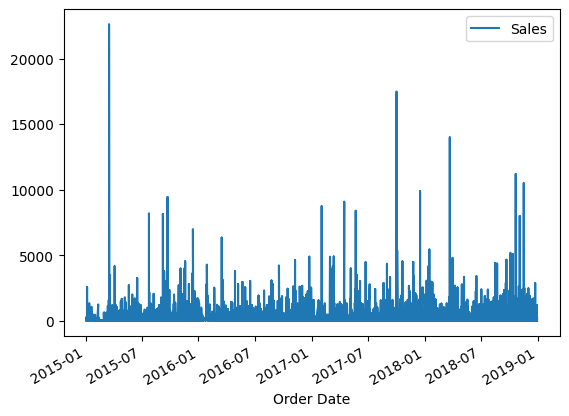

In [290]:
#Plotting the data to understand the sales distribution from the year 2015-2018
new_df.plot()

In [291]:
new_df =  pd.DataFrame(new_df['Sales'].resample('D').mean()) #Convert data into daily records (uniform timeline)

new_df = new_df.interpolate(method='linear') #Fill missing sales for smooth model training




#### resample('D') means change the time series to Daily Frequency ('D' = Daily)
#### Suppose your sales data was only recorded on certain dates (like orders placed only on random days).So some days have sales data, and some days are missing (no sales or no record).This creates daily rows even if there were no sales recorded.

#### After resampling, we get NaN (missing) values on the dates with no sales data.
#### Interpolation will Filling missing values by guessing using surrounding data.
##### Linear method → Draw a straight line between known points and fill missing values. Once the dataset is complete with no missing values — it will ready for ARIMA/SARIMA.


### Augmented Dicky Fuller test

#### The Augmented Dickey-Fuller test is a type of statistical test alsocalled a unit root test.The base of unit root test is that it helps in determining how strongly a time series is defined by a trend.

#### The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary. The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

    * Null Hypothesis(H0): Time series is not stationary
    * Alternate Hypothesis (H1): Time series is stationary
    * This result is interpreted using the p-value from the test.

    * p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    * p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.



In [294]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the 'Sales' column
adf_result = adfuller(new_df['Sales'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


# We can use below code as well uncomment to check


# adf = adfuller(new_df) 

# print(adf)
# print('\nADF = ', str(adf[0])) #more towards negative value the better
# print('\np-value = ', str(adf[1]))
# print('\nCritical Values: ')

# for key, val in adf[4].items(): #for loop to print the p-value (1%, 5% and 10%) and their respective values
#     print(key,':',val)
    

#     if adf[0] < val:
#         print('Null Hypothesis Rejected. Time Series is Stationary')
#     else:
#         print('Null Hypothesis Accepted. Time Series is not Stationary')

ADF Statistic: -20.809458514839356
p-value: 0.0


#### We will do the Model Selection using Grid Search.
##### We don’t know which combination of (p,d,q) and (P,D,Q,s) is best.
##### Use itertools.product() → It creates all possible combinations of p, d, q in the range (here 0 and 1).

#### AIC (Akaike Information Criterion) — Why This?
    * AIC helps choose the best model → Lower AIC is better
    * Formula includes both accuracy and model simplicity

    * If AIC is too high → model is bad
    * If AIC is low → model is good (less error + not too complex)

In [296]:
import itertools

# ✅ Define p, d, q range
p = d = q = range(0, 2)  # You can try (0,1,2) for better tuning

# ✅ Generate all combinations of p, d, q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]  # 12 for monthly seasonality

print('Examples of parameter combinations for SARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[2]))
print('SARIMA: {} x {}'.format(pdq[3], seasonal_pdq[3]))






Examples of parameter combinations for SARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 1, 0) x (0, 1, 0, 12)
SARIMA: (0, 1, 1) x (0, 1, 1, 12)


In [297]:
# ✅ Find the best combination based on lowest AIC
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(new_df,
                                              order=param,
                                              seasonal_order=seasonal_param,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit()
            print(f'SARIMA{param}x{seasonal_param} - AIC:{results.aic}')
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:21194.720419683938
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:20892.285535276926
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:21326.7500774028
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:20159.186343116115
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:20812.243414135526
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:20327.113003373706
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:20686.139150119507
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:20158.91639099243
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:20882.28406680822
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:20657.58454175807
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:21250.777808594292
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:20088.85509321002
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:20647.232556010582
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:20256.574098294055
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:20621.894471778985
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:20088.861299571407
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:21077.55722633678
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:20911.79772157044
SARIMA(0, 1, 0)x(0

C:\Users\amrit\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:20275.48158708407
SARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:21244.54756499376
SARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:20079.619321519593
SARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:20288.608861813344
SARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:20247.124860946424
SARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:20598.77058084705
SARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:20079.40435836889
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:20795.675610560873
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:20631.33405290758
SARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:21696.693708148116
SARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:20514.14305737219
SARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:20631.02806544181
SARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:20632.15334133039
SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:21017.876876109207
SARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:20512.66499925444
SARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:20377.3664910827
SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:20186.991028307573
SARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:21267.5547752103
SARIMA(1, 1, 1)x(0, 1, 

In [298]:
import statsmodels.api as sm 

# After choosing the combination of seasonal parameters with least AIC value, let us train the SARIMA model
mod = sm.tsa.statespace.SARIMAX(new_df,
                                        order=best_pdq,
                                        seasonal_order=best_seasonal_pdq,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False) #model defintion
results = mod.fit() #model fitting
print(results.summary().tables[1]) # displaying the result 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2151      0.011     19.823      0.000       0.194       0.236
ma.L1         -1.0000      2.893     -0.346      0.730      -6.670       4.670
ar.S.L12      -0.0376      0.035     -1.061      0.289      -0.107       0.032
ma.S.L12      -1.0000      2.893     -0.346      0.730      -6.671       4.671
sigma2      6.919e+04   4.12e-05   1.68e+09      0.000    6.92e+04    6.92e+04


In [299]:
forecast = results.forecast(steps=7) # making a forecast of 7 days later of the last date in the 'Order Date' column
print(forecast.astype('int')) 

2018-12-31    229
2019-01-01    241
2019-01-02    244
2019-01-03    229
2019-01-04    196
2019-01-05    254
2019-01-06    223
Freq: D, Name: predicted_mean, dtype: int32


In [300]:
forecast = forecast.astype('int') 
forecast_df = forecast.to_frame() 
forecast_df.reset_index(level=0, inplace=True) 
forecast_df.columns = ['Future Date', 'Predicted Sales']
forecast_df

,Future Date,Predicted Sales
0,2018-12-31,229
1,2019-01-01,241
2,2019-01-02,244
3,2019-01-03,229
4,2019-01-04,196
5,2019-01-05,254
6,2019-01-06,223
